# 대회 개요
* Playground 대회
* 실제 데이터를 바탕으로 합성 데이터를 제공
* 제공된 feature를 바탕으로 소프트웨어 결함 여부를 검출
# 대회 기간
* 시작일 23/10/03
* 종료일 23/10/23
# 평가 지표
* area under the ROC curve
    * `from sklearn.metrics import roc_auc_score`
# 데이터 요약
* feature
    * int와 float형태의 22개의 feature를 제공함
* target
    * defects를 나타내는 boolean 값
        * 결함이 있으면 True
        * 결함이 없으면 False
* feature 정리
    ```
    1. loc              : numeric % McCabe's line count of code
    2. v(g)             : numeric % McCabe "cyclomatic complexity"
    3. ev(g)            : numeric % McCabe "essential complexity"
    4. iv(g)            : numeric % McCabe "design complexity"
    5. n                : numeric % Halstead total operators + operands
    6. v                : numeric % Halstead "volume"
    7. l                : numeric % Halstead "program length"
    8. d                : numeric % Halstead "difficulty"
    9. i                : numeric % Halstead "intelligence"
    10. e               : numeric % Halstead "effort"
    11. b               : numeric % Halstead
    12. t               : numeric % Halstead's time estimator
    13. lOCode          : numeric % Halstead's line count
    14. lOComment       : numeric % Halstead's count of lines of comments
    15. lOBlank         : numeric % Halstead's count of blank lines
    16. lOCodeAndComment: numeric
    17. uniq_Op         : numeric % unique operators
    18. uniq_Opnd       : numeric % unique operands
    19. total_Op        : numeric % total operators
    20. total_Opnd      : numeric % total operands
    21: branchCount     : numeric % of the flow graph
    22. defects         : {false,true} % module has/has not one or more  reported defects
    ```

# discussion, code 리뷰

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# 데이터 둘러보기

In [12]:
data_path = '../../data/'

train = pd.read_csv(data_path+'train.csv', index_col='id')
test_df = pd.read_csv(data_path+'test.csv', index_col='id')
submission_df = pd.read_csv(data_path+'sample_submission.csv', index_col='id')
train_df = train.copy()

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67842 entries, 101763 to 169604
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                67842 non-null  float64
 1   v(g)               67842 non-null  float64
 2   ev(g)              67842 non-null  float64
 3   iv(g)              67842 non-null  float64
 4   n                  67842 non-null  float64
 5   v                  67842 non-null  float64
 6   l                  67842 non-null  float64
 7   d                  67842 non-null  float64
 8   i                  67842 non-null  float64
 9   e                  67842 non-null  float64
 10  b                  67842 non-null  float64
 11  t                  67842 non-null  float64
 12  lOCode             67842 non-null  int64  
 13  lOComment          67842 non-null  int64  
 14  lOBlank            67842 non-null  int64  
 15  locCodeAndComment  67842 non-null  int64  
 16  uniq_Op            67

In [15]:
submission_df.head()

,defects
id,
101763,0.5
101764,0.5
101765,0.5
101766,0.5
101767,0.5


In [16]:
# 데이터 요약
def resume_table(df):
    # df = df.drop(columns=target_name)
    summary_df = df.dtypes
    df = df * 1 # defects를 int형으로 바꾸기
    summary_df = summary_df.reset_index()
    summary_df.columns = ['Column', 'Dtypes']
    summary_df['결측치'] = df.isnull().sum().values
    summary_df['유니크개수'] = df.nunique().values
    summary_df['평균'] = df.describe().loc['mean'].values
    summary_df['min'] = df.describe().loc['min'].values
    summary_df['median'] = df.describe().loc['50%'].values
    summary_df['max'] = df.describe().loc['max'].values
    return summary_df.set_index('Column')

resume_table(train_df)

,Dtypes,결측치,유니크개수,평균,min,median,max
Column,,,,,,,
loc,float64,0,378,37.347160,1.0,22.00,3442.00
v(g),float64,0,106,5.492684,1.0,3.00,404.00
ev(g),float64,0,71,2.845022,1.0,1.00,165.00
iv(g),float64,0,84,3.498826,1.0,2.00,402.00
n,float64,0,836,96.655995,0.0,51.00,8441.00
v,float64,0,4515,538.280956,0.0,232.79,80843.08
l,float64,0,55,0.111634,0.0,0.09,1.00
d,float64,0,3360,13.681881,0.0,9.82,418.20
i,float64,0,5171,27.573007,0.0,23.36,569.78


In [17]:
train_df['defects'] = train_df['defects'].astype(int)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

In [18]:
# countplot 백분률 추가
def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size*100

        ax.text(
            left_coord+width/2.0,
            height/2.0,
            f'{percent:.1f}%',
            ha='center'
        )

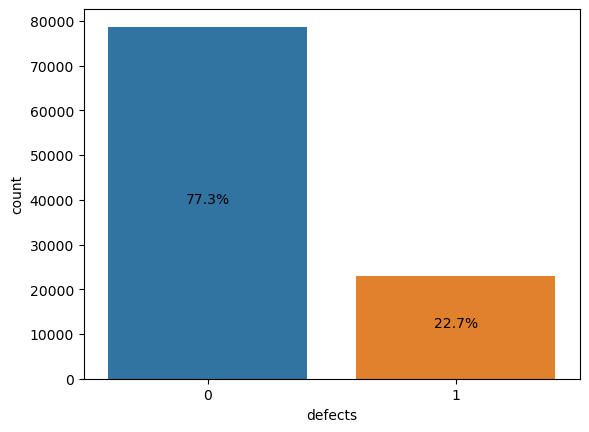

In [19]:
# target 분포 출력
ax = sns.countplot(data=train_df, x='defects')
write_percent(ax, train_df.shape[0])

<Axes: xlabel='id'>

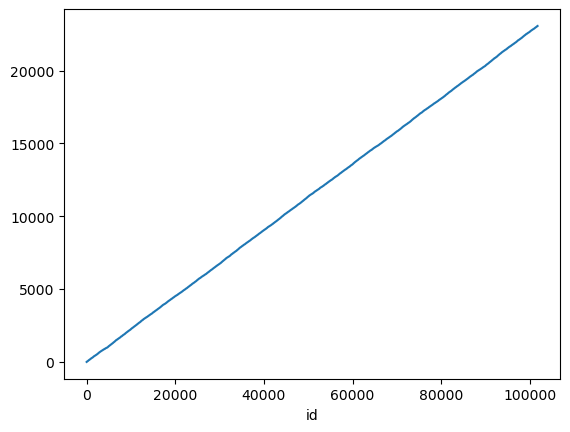

In [20]:
# defects의 분포가 고른지 확인
train_df['defects'].cumsum().plot()

In [21]:
train_df.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

In [22]:
import matplotlib.gridspec as gridspec

def plot_feature_target(df, cont_features, grid_width, grid_height, bin_nums=5, figsize=(10,8)):
    plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(grid_width,grid_height)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    for idx, cont_feature in enumerate(cont_features):
        df[cont_feature+'_c'] = pd.cut(df[cont_feature], bin_nums)
        ax = plt.subplot(grid[idx])
        sns.barplot(data=df, x=cont_feature+'_c', y='defects', palette='Set2', ax=ax)
        ax.tick_params(axis='x', labelrotation=10)

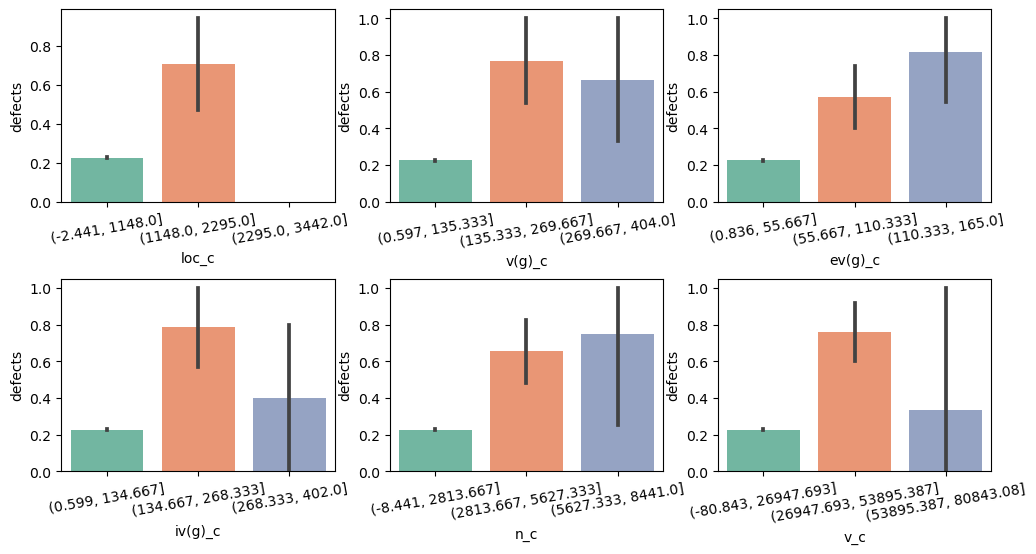

In [23]:
column_names = train_df.columns[:6]
plot_feature_target(train_df, column_names, 2, 3, bin_nums=3, figsize=(12,6))

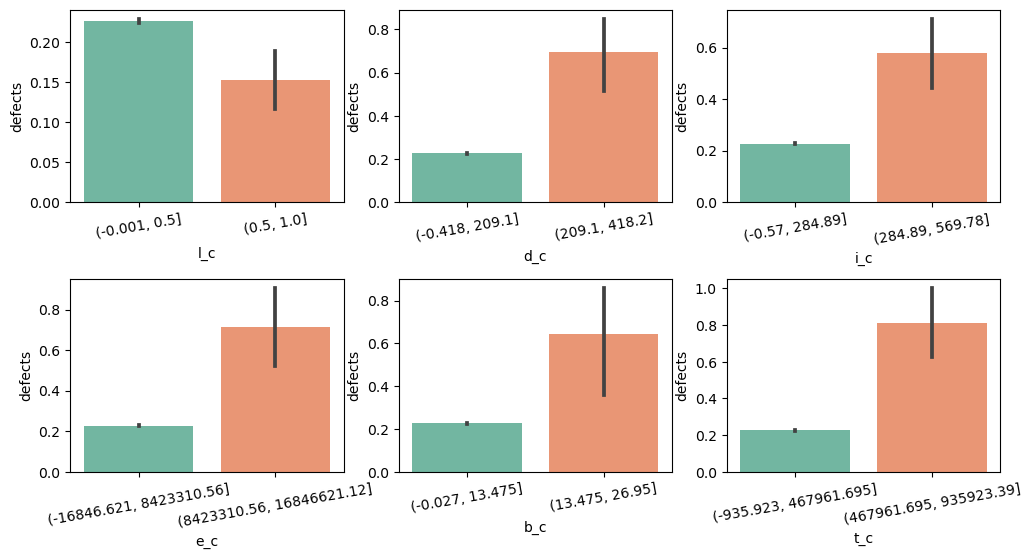

In [24]:
column_names = train_df.columns[6:12]
plot_feature_target(train_df, column_names, 2, 3, bin_nums=2, figsize=(12,6))

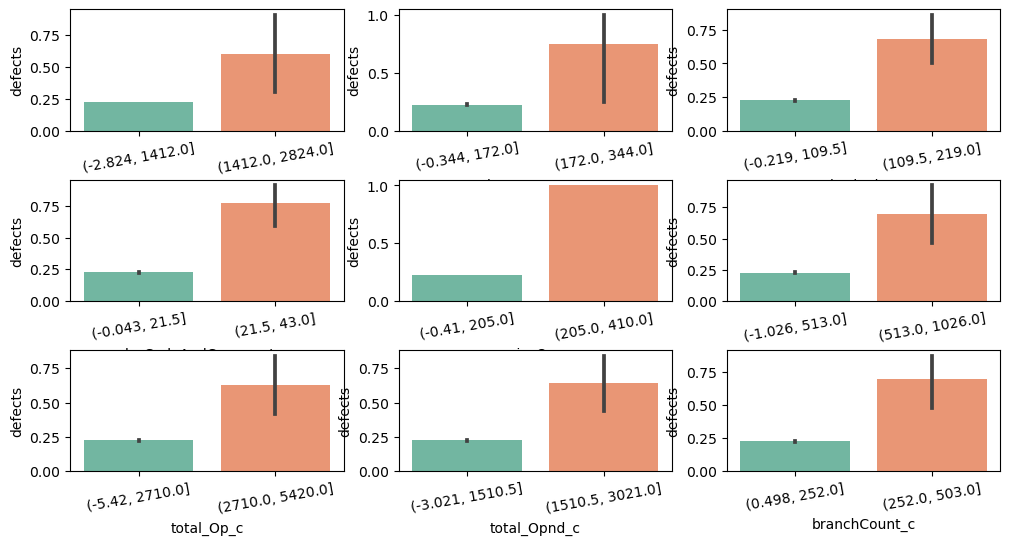

In [25]:
column_names = train_df.columns[12:21]
plot_feature_target(train_df, column_names, 3, 3, bin_nums=2, figsize=(12,6))

In [26]:
pd.cut([1,2,3,4,5,6,7,8,9], 3)

[(0.992, 3.667], (0.992, 3.667], (0.992, 3.667], (3.667, 6.333], (3.667, 6.333], (3.667, 6.333], (6.333, 9.0], (6.333, 9.0], (6.333, 9.0]]
Categories (3, interval[float64, right]): [(0.992, 3.667] < (3.667, 6.333] < (6.333, 9.0]]

<Axes: >

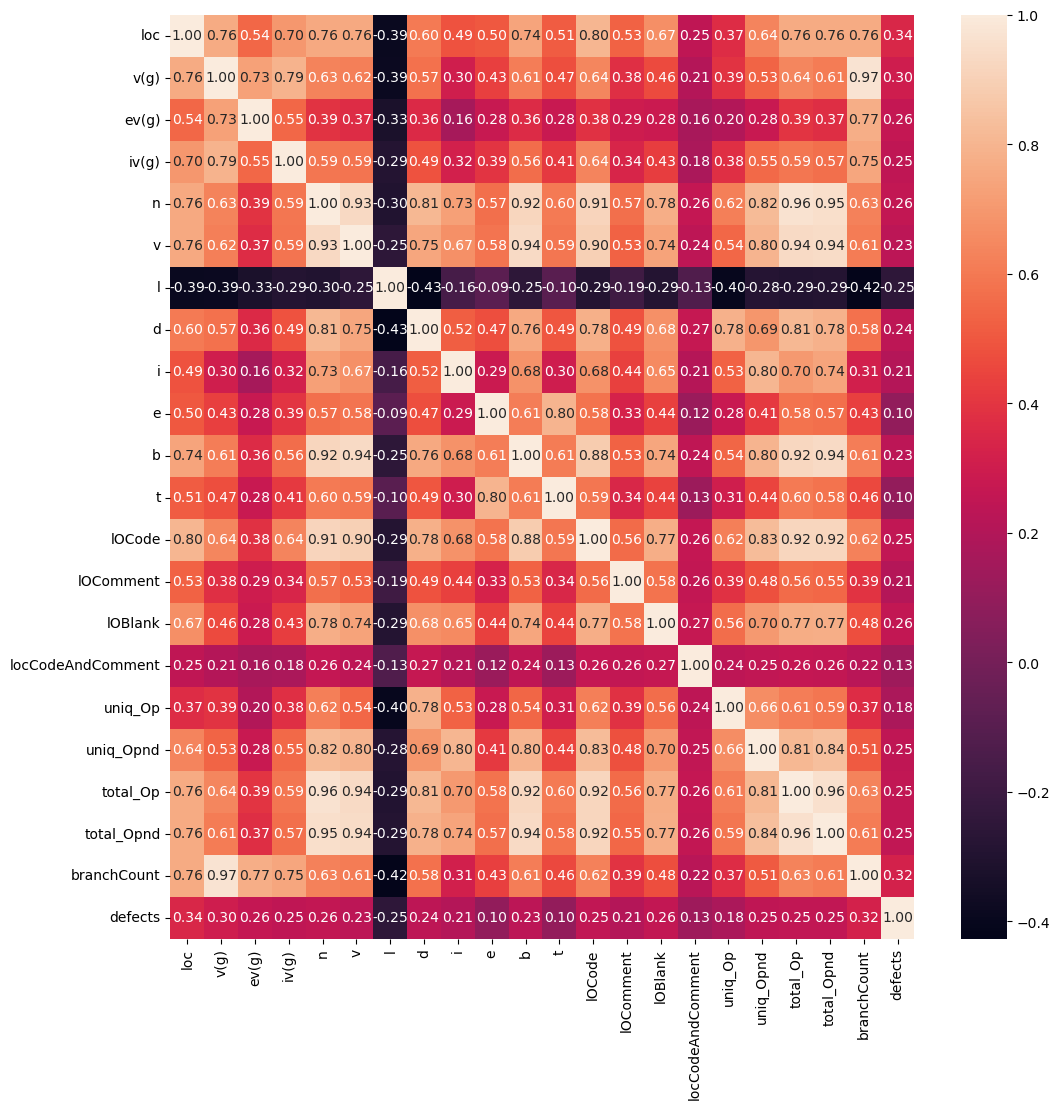

In [27]:
df = train
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
X = train.iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,loc,6.816061
1,v(g),29.859972
2,ev(g),3.735640
3,iv(g),4.459657
4,n,24.689084
5,v,15.373596
6,l,1.849539
7,d,11.519900
8,i,9.364301
9,e,3.155124


In [29]:
# https://www.kaggle.com/code/vuppalaadithyasairam/software-defects-data-cleaning-eda#Treatment-for-uncorrelated-values--Remove-the-features